## Long Short Term Memory (LSTM) Neural Network

In [2]:
# Import essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from functools import reduce
from pandas import read_csv
from matplotlib import pyplot

# Import LSTM libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
# from keras.preprocessing.timeseries import TimeseriesGenerator
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error
import tensorflow as tf 
tf.keras.preprocessing.timeseries_dataset_from_array

<function keras.src.utils.timeseries_dataset_utils.timeseries_dataset_from_array(data, targets, sequence_length, sequence_stride=1, sampling_rate=1, batch_size=128, shuffle=False, seed=None, start_index=None, end_index=None)>

### Predicting CPI using lagged CPI data

In [3]:
cpi_df = pd.read_csv('cleaned_cpi.csv')

# Set date column as index
#cpi_df.set_index('Date', inplace = True)

# Remove change columns as we will be using the absolute index value for this
cpi_df.drop(columns = ['Value', 'ChangePercentYear'], axis = 1, inplace = True)
cpi_df.dropna(inplace = True)
len(cpi_df)

1310

In [4]:
cpi_train = cpi_df.iloc[:1190]
cpi_test = cpi_df.iloc[1190:]

# Pre-process data using a minmaxscaler to convert all data attributes to a range of 0-1
# Instantiate scaler object
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(cpi_train.set_index('Date'))
scaled_cpi_train = scaler.transform(cpi_train.set_index('Date'))
scaled_cpi_test = scaler.transform(cpi_test.set_index('Date'))

In [5]:
# define generator
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
n_input = 12  # We will use the last 12 months of CPI data to predict the next month
n_features = 1
generator = TimeseriesGenerator(scaled_cpi_train, scaled_cpi_train, length=n_input, batch_size=1)

In [6]:
# define our LSTM model
from tensorflow.keras.models import Sequential
model = Sequential()
# LSTM with 100 nodes
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')   # loss function assigned to mean square error
model.summary()

# fit the model
model.fit(generator, epochs = 5)

d:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100)            │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,901 (159.77 KB)

 Trainable params: 40,901 (159.77 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
   9/1178 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.0459    

d:\Python\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1178/1178 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - loss: 0.0183
Epoch 2/5
1178/1178 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.0195
Epoch 3/5
1178/1178 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.0202
Epoch 4/5
1178/1178 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.0141
Epoch 5/5
1178/1178 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 0.0150


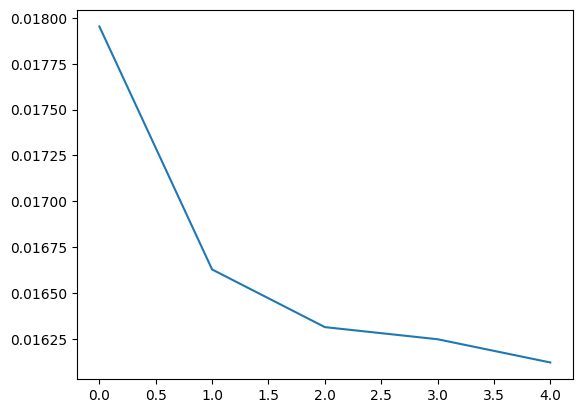

In [7]:
# plot the loss per epoch
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [8]:
# Use the trained model to generate and store our test predictions
test_predictions = []

first_eval_batch = scaled_cpi_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))
n=0

for i in range(len(scaled_cpi_test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # remove the first value and update the batch with the next value from the test set
    current_batch = np.append(current_batch[:,1:,:],scaled_cpi_test[n:n+1].reshape((1, 1, n_features)),axis=1)
    n += 1



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━

In [9]:
# Convert our predictions back to their pre scaled forms
true_predictions = scaler.inverse_transform(test_predictions)

# Apend the predictions back to the test data set
cpi_test['Predictions'] = true_predictions

C:\Users\Suryanshu Choudhary\AppData\Local\Temp\ipykernel_15956\3862874477.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cpi_test['Predictions'] = true_predictions


Test RMSE: 0.0031872307462068304


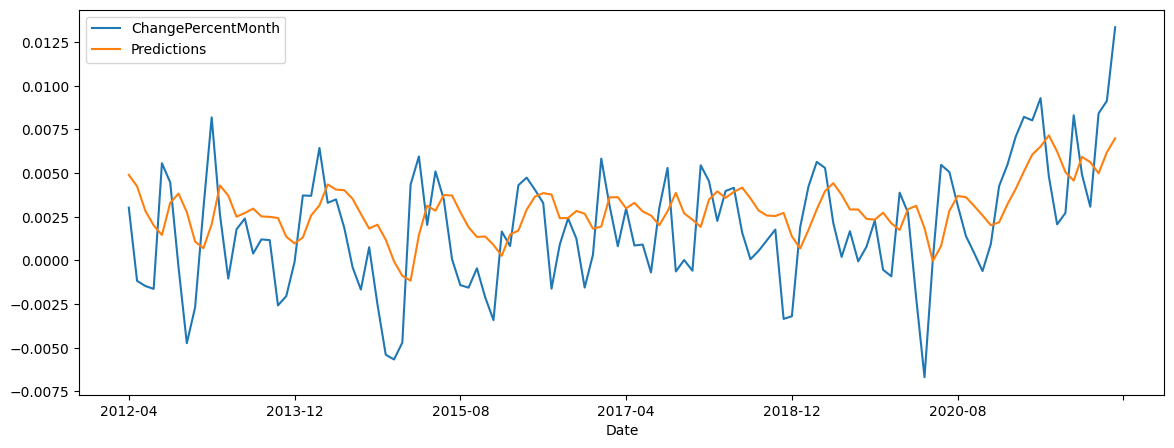

In [10]:
cpi_test.set_index('Date', inplace = True)
cpi_test.plot(figsize=(14,5))
uni_rmse=sqrt(mean_squared_error(cpi_test['ChangePercentMonth'],cpi_test['Predictions']))
print('Test RMSE:' , uni_rmse)

### Multivariate Forecasting of CPI with LTSMD

In [11]:
# Import all datasets
oil_data_clean = pd.read_csv('cleaned_oil.csv')
ppi_data_clean = pd.read_csv('cleaned_ppi.csv')
unemp_data_clean = pd.read_csv('cleaned_unemp.csv')
lcpi_data_clean = pd.read_csv('cleaned_lagged_cpi.csv')
cpi_data_clean = pd.read_csv('cleaned_cpi.csv')

In [12]:
oil_data_clean.drop(columns = ['ChangePercentYear', 'Value'], axis = 1, inplace = True)
ppi_data_clean.drop(columns = ['ChangePercentYear', 'Value'], axis = 1, inplace = True)
unemp_data_clean.drop(columns = ['ChangePercentYear', 'Value'], axis = 1, inplace = True)
lcpi_data_clean.drop(columns = ['ChangePercentYear', 'Value'], axis = 1, inplace = True)
cpi_data_clean.drop(columns = ['ChangePercentYear', 'Value'], axis = 1, inplace = True)

In [13]:
oil_data_clean.columns = ['Date','Oil']
oil_data_clean.dropna(inplace = True)
ppi_data_clean.columns = ['Date','PPI']
ppi_data_clean.dropna(inplace = True)
unemp_data_clean.columns = ['Date','Unemployment']
unemp_data_clean.dropna(inplace = True)
lcpi_data_clean.columns = ['Date','LaggedCPI']
lcpi_data_clean.dropna(inplace = True)
cpi_data_clean.columns = ['Date','CPI']
cpi_data_clean.dropna(inplace = True)

dataframe_list = [cpi_data_clean, oil_data_clean, ppi_data_clean, unemp_data_clean, lcpi_data_clean]
# Join all datasets together
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['Date'], how='inner'), dataframe_list)
df_merged.set_index('Date', inplace = True)

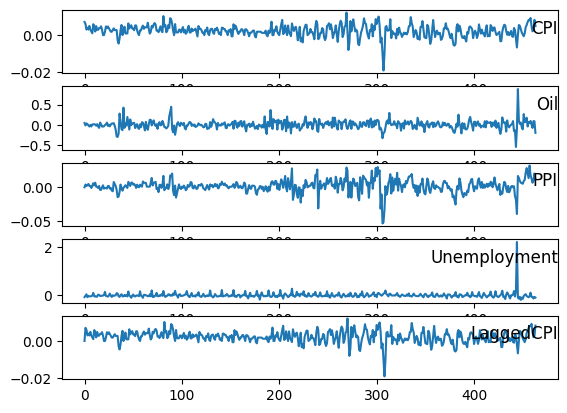

In [14]:
values = df_merged.values
# specify columns to plot
groups = [0, 1, 2, 3, 4]
i = 1
# plot each column
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(df_merged.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

#### Data Preparation for LSTM Model


In [15]:
df_merged

,CPI,Oil,PPI,Unemployment,LaggedCPI
Date,,,,,
1983-04,0.007150,0.046464,0.000000,-0.074074,0.000000
1983-05,0.006085,-0.012406,0.003984,-0.020000,0.007150
1983-06,0.003024,0.037355,0.001984,0.040816,0.006085
1983-07,0.004020,0.019758,0.002970,-0.078431,0.003024
1983-08,0.003003,-0.012813,0.004936,-0.021277,0.004020
...,...,...,...,...,...
2021-07,0.004811,0.006533,0.012888,-0.065574,0.009291
2021-08,0.002066,-0.073698,0.006750,-0.070175,0.004811
2021-09,0.002716,0.095328,0.009695,-0.132075,0.002066


In [16]:
# Splitting the dataset into train and test sets
df_train = df_merged.iloc[:357]
df_test = df_merged.iloc[357:]

In [17]:
# Use MinMaxScaler to normalise are values by scaling down values between a range of -1 to 1
# Instantiate scaler objects
x_scaler = MinMaxScaler(feature_range=(-1, 1))
y_scaler = MinMaxScaler(feature_range=(-1, 1))

x_train = x_scaler.fit_transform(df_train[['Oil','PPI','Unemployment','LaggedCPI']])
y_train = y_scaler.fit_transform(df_train[['CPI']])

x_test = x_scaler.transform(df_test[['Oil','PPI','Unemployment','LaggedCPI']])
y_test = y_scaler.transform(df_test[['CPI']])

In [18]:
# reshape input to be 3D [samples, timesteps, features]
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(357, 1, 4) (357, 1) (107, 1, 4) (107, 1)


d:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
357/357 - 5s - 13ms/step - loss: 0.0274 - val_loss: 0.0216
Epoch 2/30
357/357 - 2s - 7ms/step - loss: 0.0166 - val_loss: 0.0274
Epoch 3/30
357/357 - 1s - 4ms/step - loss: 0.0164 - val_loss: 0.0333
Epoch 4/30
357/357 - 1s - 4ms/step - loss: 0.0163 - val_loss: 0.0407
Epoch 5/30
357/357 - 2s - 5ms/step - loss: 0.0162 - val_loss: 0.0488
Epoch 6/30
357/357 - 1s - 4ms/step - loss: 0.0161 - val_loss: 0.0573
Epoch 7/30
357/357 - 1s - 3ms/step - loss: 0.0160 - val_loss: 0.0660
Epoch 8/30
357/357 - 2s - 4ms/step - loss: 0.0159 - val_loss: 0.0747
Epoch 9/30
357/357 - 1s - 4ms/step - loss: 0.0158 - val_loss: 0.0835
Epoch 10/30
357/357 - 2s - 4ms/step - loss: 0.0157 - val_loss: 0.0921
Epoch 11/30
357/357 - 1s - 4ms/step - loss: 0.0156 - val_loss: 0.1005
Epoch 12/30
357/357 - 1s - 3ms/step - loss: 0.0155 - val_loss: 0.1085
Epoch 13/30
357/357 - 1s - 4ms/step - loss: 0.0154 - val_loss: 0.1160
Epoch 14/30
357/357 - 1s - 3ms/step - loss: 0.0154 - val_loss: 0.1228
Epoch 15/30
357/357 - 2s - 4

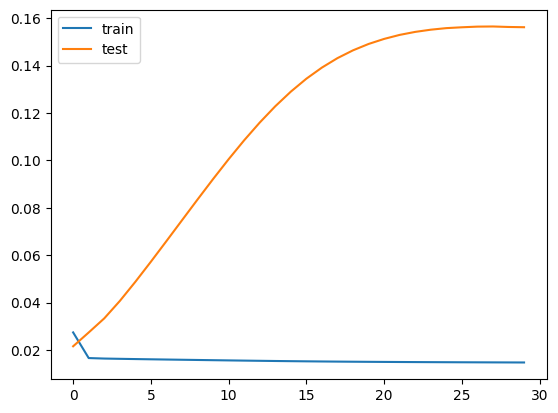

In [19]:
# design network with 100 neurons
model = Sequential()
model.add(LSTM(100, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
# fit network
history = model.fit(x_train, y_train, epochs=30, batch_size=1, validation_data=(x_test, y_test), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

Testing the Model

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step
Test RMSE: 0.00619952017330299


C:\Users\Suryanshu Choudhary\AppData\Local\Temp\ipykernel_15956\2263781401.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['Predicted CPI'] = inv_yhat


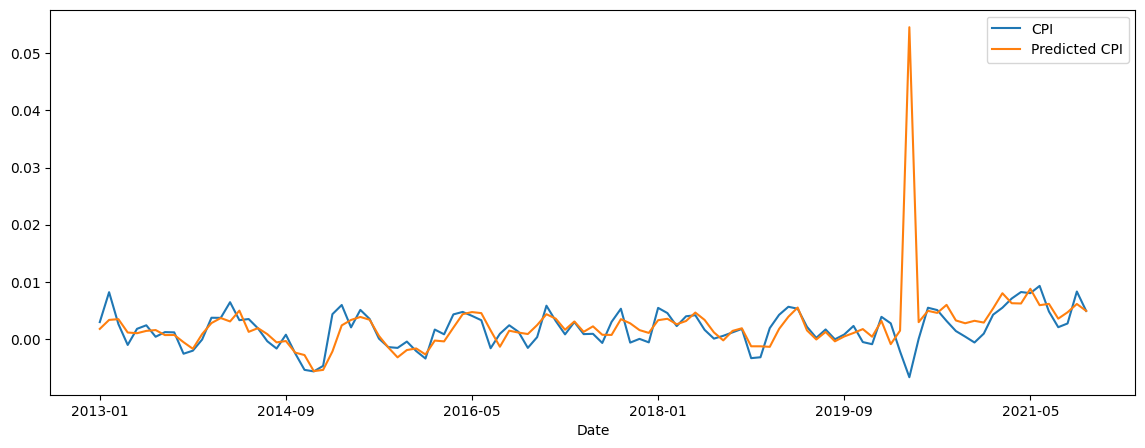

In [20]:
# make a prediction
yhat = model.predict(x_test)
# invert scaling for our forcast
inv_yhat = y_scaler.inverse_transform(yhat)
# Add our forecast to the test dataframe and plot the results
df_test['Predicted CPI'] = inv_yhat
df_test[['CPI','Predicted CPI']].plot(figsize=(14,5))
# Calculate RMSE
multi_rmse=sqrt(mean_squared_error(df_test['CPI'],df_test['Predicted CPI']))
print('Test RMSE:' , multi_rmse)

In [21]:
df_test

,CPI,Oil,PPI,Unemployment,LaggedCPI,Predicted CPI
Date,,,,,,
2013-01,0.002957,0.061751,0.004963,0.118421,-0.002693,0.001770
2013-02,0.008190,-0.055801,0.008889,-0.047059,0.002957,0.003339
2013-03,0.002615,0.056274,-0.001468,-0.061728,0.008190,0.003472
2013-04,-0.001040,-0.038774,-0.002451,-0.065789,0.002615,0.001135
2013-05,0.001780,-0.015943,0.002948,0.028169,-0.001040,0.001015
...,...,...,...,...,...,...
2021-07,0.004811,0.006533,0.012888,-0.065574,0.009291,0.006148
2021-08,0.002066,-0.073698,0.006750,-0.070175,0.004811,0.003562
2021-09,0.002716,0.095328,0.009695,-0.132075,0.002066,0.004672


In [22]:
print('Univariate Long Short Memory Network RMSE:' , uni_rmse)
print('Multivariate Long Short Memory Network RMSE:' , multi_rmse)

Univariate Long Short Memory Network RMSE: 0.0031872307462068304
Multivariate Long Short Memory Network RMSE: 0.00619952017330299
